# 7. Ensemble Learning and Random Forests

Main argument behind ensemble learning is the principle *wisdom of crowds* which aggregates the opinions of many rather than a single expert for a decision. ML analogy is using more than one estimator and averaging or voting the results. Three important ensemble methods are **bagging**, **boosting** and **stacking**.

> **Remark:** Of course this principle must be approached with a grain of salt. It's very clear that wisdom of experts supersedes wisdom of crowds regarding the working principle of combustion engine.

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.style.use("ggplot")


## 7.1 Voting Classifiers

Provided that each classifier is independent and performs better than random prediction, results of voting between all the results individual classifier outputs are generally better than a single one. Sadly, the first condition is violated since every classifier is trained on the same dataset. Haply, if we choose reasonable different algorithms, we can overcome this problem with reasonable success. 

There are two types of voting scheme:
- **Hard**, directly votes between results
- **Soft**, averages the probability results granted that estimator has `predict_proba` method.

In [71]:
from sklearn.datasets import make_moons
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

moons = make_moons(n_samples=1000, noise=0.8)
X_train, X_test, y_train, y_test = train_test_split(moons[0], moons[1], train_size=0.8)

log_clf = LogisticRegression()
tree_clf = DecisionTreeClassifier(max_depth=3)
svc = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[("tc", tree_clf), ("svc", svc), ("lr", log_clf)], voting="soft"
)

for clf in [log_clf, tree_clf, svc, voting_clf]:
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print(f"{clf.__class__.__name__} accuracy: {accuracy}")


LogisticRegression accuracy: 0.755
DecisionTreeClassifier accuracy: 0.73
SVC accuracy: 0.73
VotingClassifier accuracy: 0.755


## 7.2 Bagging and Pasting

Bagging is the amalgamation of bootstrapping and aggregating. Different predictors of the same type is trained on the subsets of dataset. If subsets are sampled without replacement it's called bagging, otherwise it is called pasting.

After all models are trained, the result is chosen with hard voting or averaging for regression tasks. The process can easily be parallelized and immune to scalability issues.

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
preds = bag_clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy}\nOOB score {bag_clf.oob_score_}")


Accuracy: 0.815
OOB score 0.715


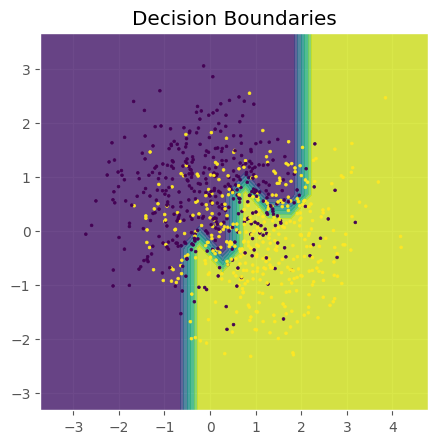

In [72]:
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx1, xx2 = np.meshgrid(
    np.arange(x1_min, x1_max, 0.5),
    np.arange(x2_min, x2_max, 0.5)
)

Z = bag_clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)
plt.contourf(xx1,xx2,Z,alpha=0.8)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=4)
plt.title("Decision Boundaries")
plt.show()



## 7.3 Random Patches and Random Subspaces

We can also sample input features during training. Sampling both instances and features is called **random patches**. Another method is to sample instances without bootstrap and features with bootstrap. This is called **random subspaces**.

## 7.4 Random Forests

**Random forest** is an ensemble algorithm consisting of decision trees. It's practically the same as bagging classifier previously demonstrated. The difference for default instantiation is such that for sampling whole training set is used.

Another forest type approach is **extra tree classifier** which also randomizes feature thresholds. It's hard to decide which one performs better experimenting, so both approaches need to be run before deciding which one to use. 

Finally, random forest can be used to determine feature importance. This feature can be utilized as an upstream process for feature selection and then found features are to be fed to the next stage in the pipeline. 

F1 score: 0.9593571428571429


<AxesSubplot:>

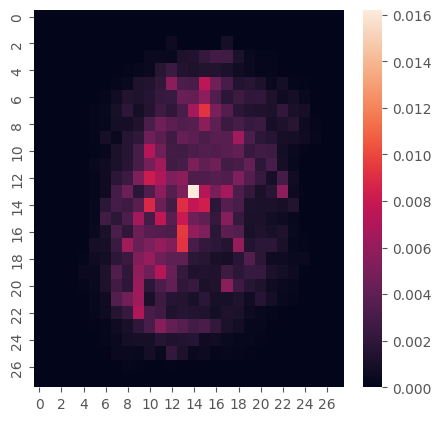

In [69]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from collections import Counter
import seaborn as sns

rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1)

mnist = fetch_openml("mnist_784", version=1)

X, y = mnist.data, mnist.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True
)

rfc.fit(X_train, y_train)
feature_importance = rfc.feature_importances_
preds = rfc.predict(X_test)
print(f"F1 score: {f1_score(y_test, preds, average='micro')}")
feature_importance = feature_importance.reshape(28, 28)
sns.heatmap(feature_importance)
plt.show()

## 7.5 Boosting

## 7.6 Stacking